In [337]:
from velocity_plot import velocity_plot as vpl
from turtle import color
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from sampling import *
import pandas as pd
from colormap import *
import random
import os

In [338]:
def corr_coeff(ematrix, vmatrix, i):
    '''
    Calculate the correlation between the predict velocity (velocity_matrix[:,i])
    and the difference between a cell and every other (cell_matrix - cell_matrix[:, i])
    '''
    # ematrix = cell_matrix
    # vmatrix = velocity_matrix
    ematrix = ematrix.T
    vmatrix = vmatrix.T
    ematrix = ematrix - ematrix[i, :]
    vmatrix = vmatrix[i, :][None, :]
    ematrix_m = ematrix - ematrix.mean(1)[:, None]
    vmatrix_m = vmatrix - vmatrix.mean(1)[:, None]

    # Sum of squares across rows
    ematrix_ss = (ematrix_m**2).sum(1)
    vmatrix_ss = (vmatrix_m**2).sum(1)
    cor = np.dot(ematrix_m, vmatrix_m.T) / \
        np.sqrt(np.dot(ematrix_ss[:, None], vmatrix_ss[None]))
    return cor.T


def velocity_correlation(cell_matrix, velocity_matrix):
    """Calculate the correlation between the predict velocity (velocity_matrix[:,i])
    and the difference between a cell and every other (cell_matrix - cell_matrix[:, i])

    Arguments
    ---------
    cell_matrix: np.ndarray (ngenes, ncells)
        gene expression matrix
    velocity_matrix: np.ndarray (ngenes, ncells)
    Return
    ---------
    c_matrix: np.ndarray (ncells, ncells)
    """
    c_matrix = np.zeros((cell_matrix.shape[1], velocity_matrix.shape[1]))
    for i in range(cell_matrix.shape[1]):
        c_matrix[i, :] = corr_coeff(cell_matrix, velocity_matrix, i)[0, :]
    
    
    np.fill_diagonal(c_matrix, 0)
    return c_matrix


def velocity_projection(cell_matrix, velocity_matrix, embedding, knn_embedding):
    '''
    cell_matrix: np.ndarray (ngenes, ncells)
        gene expression matrix
    velocity_matrix: np.ndarray (ngenes, ncells)
    '''
    # cell_matrix = np_s0[:,sampling_ixs]
    # velocity_matrix = np_dMatrix[:,sampling_ixs]
    
    def gaussian_kernel(X, mu=0, sigma=1):
        return np.exp(-(X - mu)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)
    
    sigma_corr = 0.05
    cell_matrix[np.isnan(cell_matrix)] = 0
    velocity_matrix[np.isnan(velocity_matrix)] = 0
    corrcoef = velocity_correlation(cell_matrix, velocity_matrix)
    probability_matrix = np.exp(corrcoef / sigma_corr)*knn_embedding.A
    probability_matrix /= probability_matrix.sum(1)[:, None]
    unitary_vectors = embedding.T[:, None, :] - embedding.T[:, :, None]
    with np.errstate(divide='ignore', invalid='ignore'):
        unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)
        np.fill_diagonal(unitary_vectors[0, ...], 0)
        np.fill_diagonal(unitary_vectors[1, ...], 0)
    velocity_embedding = (probability_matrix * unitary_vectors).sum(2)
    velocity_embedding -= (knn_embedding.A * unitary_vectors).sum(2) / \
        knn_embedding.sum(1).A.T  # embedding_knn.A *
    velocity_embedding = velocity_embedding.T
    
    return velocity_embedding, probability_matrix


def data_reshape(load_cellDancer):
    '''
    load detail file
    return expression matrix and velocity (ngenes, ncells)
    '''
    psc = 1
    gene_names = load_cellDancer['gene_name'].drop_duplicates().to_list()
    # cell_number = load_cellDancer[load_cellDancer['gene_name']==gene_names[0]].shape[0]
    # load_cellDancer['index'] = np.tile(range(cell_number),len(gene_names))
    load_cellDancer['index'] = 0
    for g in gene_names:
        load_cellDancer.loc[load_cellDancer['gene_name'] == g, 'index'] = range(
            load_cellDancer[load_cellDancer['gene_name'] == g].shape[0])
    s0_reshape = load_cellDancer.pivot(
        index='gene_name', values='s0', columns='index')
    s1_reshape = load_cellDancer.pivot(
        index='gene_name', values='s1', columns='index')
    dMatrix = s1_reshape-s0_reshape
    np_s0_reshape = np.array(s0_reshape)
    np_dMatrix = np.array(dMatrix)
    np_dMatrix2 = np.sqrt(np.abs(np_dMatrix) + psc) * \
        np.sign(np_dMatrix)  # (2159, 18140)
    return(np_s0_reshape, np_dMatrix2)


In [339]:
raw_data_path = "/Users/pengzhizhang/Documents/test_data/denGyr_full.csv"
load_raw_data = pd.read_csv(raw_data_path, names=[
                            'gene_list', 'u0', 's0', "clusters", 'cellID', 'embedding1', 'embedding2'])


detail_result_path = '/Users/pengzhizhang/Documents/test_data'
output_path = '/Users/pengzhizhang/Documents/test_data'





In [340]:
load_cellDancer = pd.read_csv('/Users/pengzhizhang/Documents/test_data/detail_e307.csv')

In [341]:
gene_choice=list(set(load_cellDancer.gene_name))
n_neighbors=100
add_amt_gene=10
data_df = load_raw_data[['gene_list', 'u0', 's0', 'cellID',
                             'embedding1', 'embedding2']][load_raw_data.gene_list.isin(gene_choice)]

random.seed(10)
embedding_downsampling, sampling_ixs, knn_embedding = downsampling_embedding(data_df,
                                                                            para='neighbors',
                                                                            target_amount=0,
                                                                            step_i=60,
                                                                            step_j=60,
                                                                            n_neighbors=n_neighbors)


neighbors


In [342]:
data_df.shape
embedding_downsampling.shape

(3609860, 6)

(885, 2)

In [343]:
np_s0, np_dMatrix = data_reshape(load_cellDancer)  # 2min for 200 genes

np_dMatrix_all=np_dMatrix

np_s0_all=np_s0

In [344]:
embedding_df = load_raw_data[load_raw_data.gene_list == list(
    load_raw_data.gene_list[0])[0]][['embedding1', 'embedding2']]

embedding = embedding_df.to_numpy()

velocity_embedding, probability_matrix = velocity_projection(
    np_s0_all[:, sampling_ixs], np_dMatrix_all[:, sampling_ixs], embedding[sampling_ixs, :], knn_embedding)

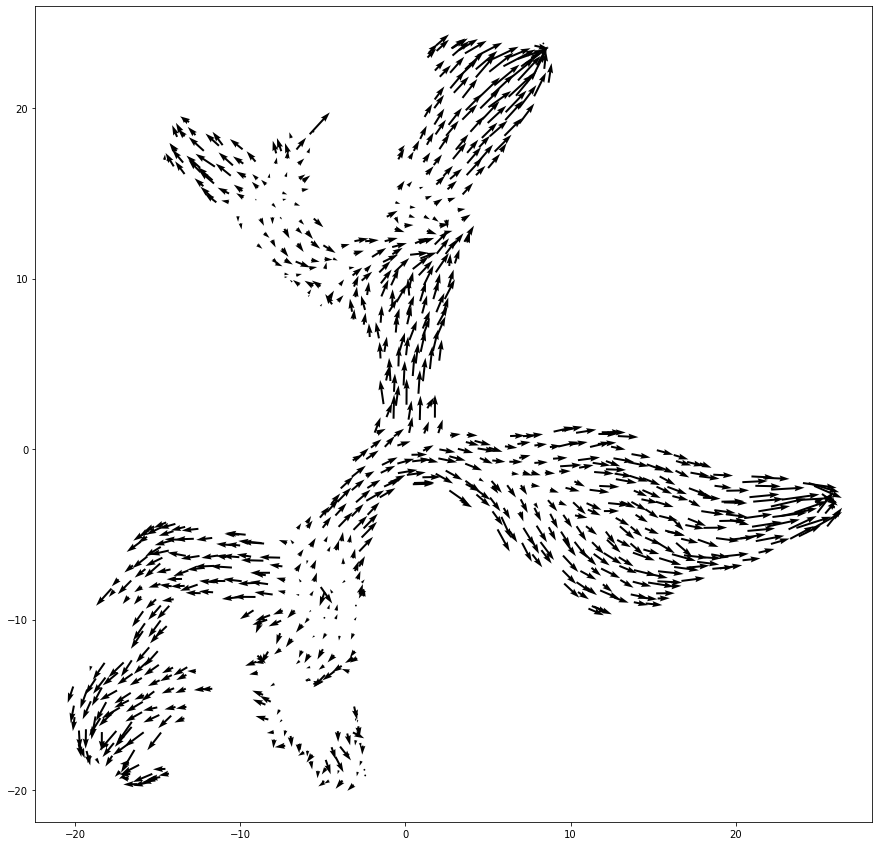

In [345]:
plt.rcParams["figure.figsize"] = (15,15)
plt.quiver(embedding[sampling_ixs, 0],embedding[sampling_ixs, 1],
          velocity_embedding[:,0], velocity_embedding[:,1])

In [56]:
np_dMatrix_all[:,sampling_ixs]

array([[ 1.06800471,  1.13935488, -1.06582408, ..., -1.11794955,
         1.19849326, -1.06071923],
       [-1.00000968,  1.00468726,  1.01097547, ...,  1.00120689,
         1.00031938,  1.01088679],
       [-1.00001507,  1.01083822,  1.01663346, ...,  1.00067474,
         1.00068393,  1.00495055],
       ...,
       [-1.00762306, -1.01065764, -1.00081074, ..., -1.00310971,
        -1.00795118, -1.00088477],
       [-1.00002669,  0.        , -1.00077234, ..., -1.0000895 ,
        -1.00001681,  1.00074652],
       [ 1.00060625,  1.00033641, -1.00000468, ..., -1.00002038,
         1.00149968, -1.00000265]])

In [223]:
def gaussian_kernel(X, mu=0, sigma=1):
    return np.exp(-(X - mu)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

In [286]:
probability_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [372]:
def compute_transition_matrix(prob_matrix, embedding, knn_embedding, mix_ratio=0.2):
    
    # sigma_D is set to the average distance between the closest neighbours
    X = pairwise_distances(embedding)
    
    X_temp = X + np.identity(X.shape[0])*X.max()
    near_dist = X_temp.min(axis=0)
    sigma_D = near_dist.mean()
    sigma_W = 0.5 * sigma_D
    W = gaussian_kernel(X, sigma=sigma_W)
    W /= W.sum(1)[:,None]
    
    D = prob_matrix * gaussian_kernel(X, sigma=sigma_D)
    np.fill_diagonal(D, D.max(1))
    D /= D.sum(1)[:,None]
    
    T = W*mix_ratio + D*(1-mix_ratio)
    
    T[T < np.percentile(T, 25)] = 0
    
    
    
    T /= T.sum(1)[:,None]
    
    
    
    return T, W, D

In [373]:
transition_matrix, W, D = compute_transition_matrix(probability_matrix, 
                                              embedding_downsampling.to_numpy(), 
                                              knn_embedding, 
                                              0.2)

In [376]:
def run_Markov(init, transition_matrix, nsteps=2500):
    '''
    Perform Markov chain simulation using the probability matrix
    transition probability matrix [ncells, ncells] <== computed from the downsampled embedding 
    init state <== [ncells]
    '''
    ncells = np.shape(probability_matrix)[0]
    
    # solving for the stationary states
    # by nsteps of iterations
    for x in range(nsteps):
        state = np.dot(init, transition_matrix)
        init = state
    
    return(state)

In [380]:
embedding_lookup = load_raw_data.loc[embedding_downsampling.index]
embedding_lookup = embedding_lookup.drop_duplicates(subset='cellID')
embedding_lookup = embedding_lookup.assign(down_sample_index = list(range(embedding_downsampling.shape[0])))


In [436]:
def view_state(state, base=embedding):
    plt.scatter(embedding[sampling_ixs,0], embedding[sampling_ixs,1], c=state,cmap='viridis_r', s=0.7, vmin=0, vmax=0.2, )
    plt.axis('off')
    
def view_transition(cell_index):
    state = np.zeros(probability_matrix.shape[0])
    plt.scatter(embedding[sampling_ixs,0], embedding[sampling_ixs,1], c=state,cmap='viridis_r', vmin=0, vmax=0.2)
    plt.scatter(embedding_downsampling.to_numpy()[cell_index,0], embedding_downsampling.to_numpy()[cell_index,1])

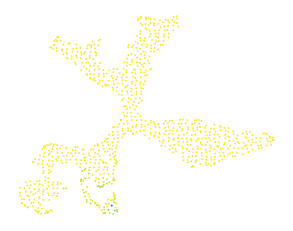

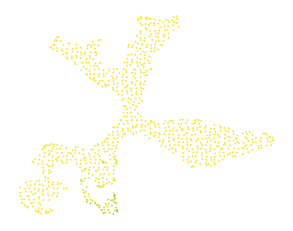

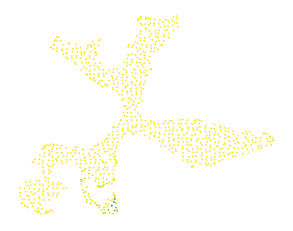

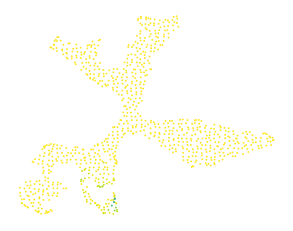

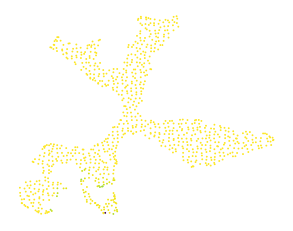

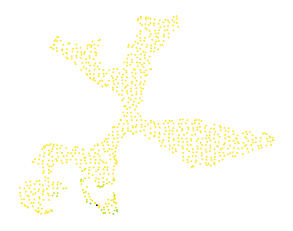

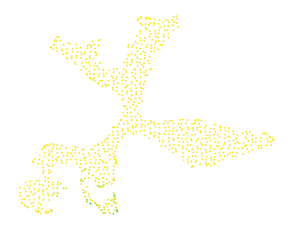

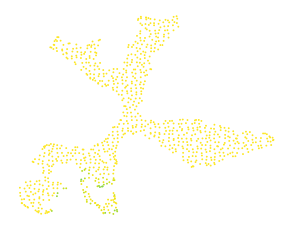

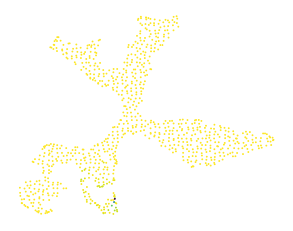

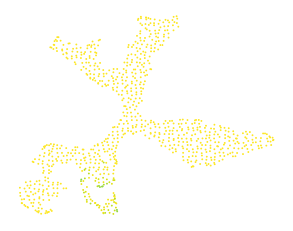

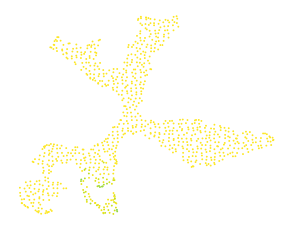

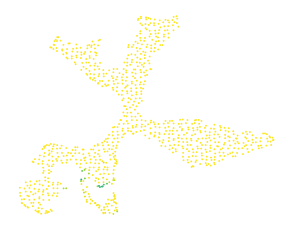

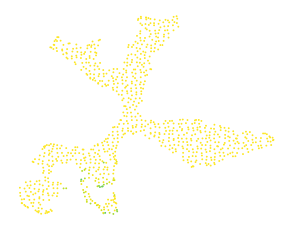

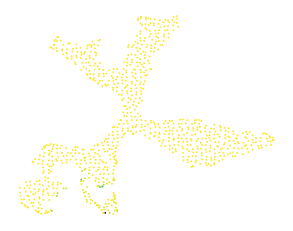

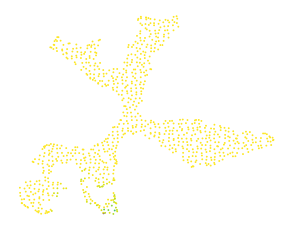

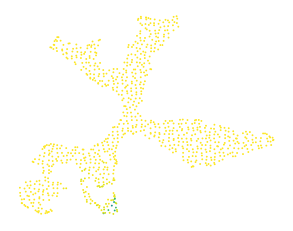

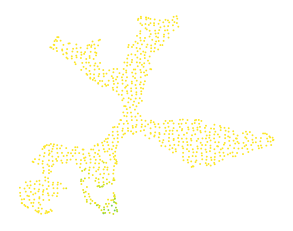

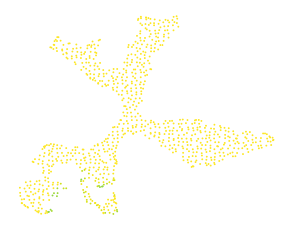

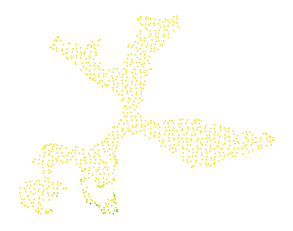

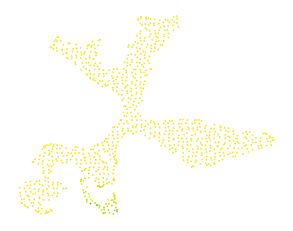

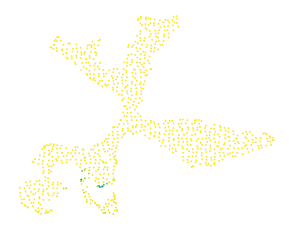

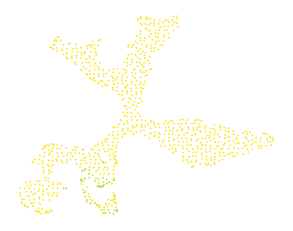

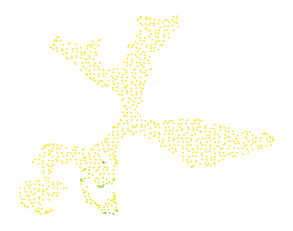

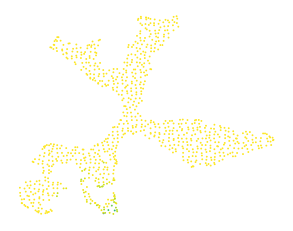

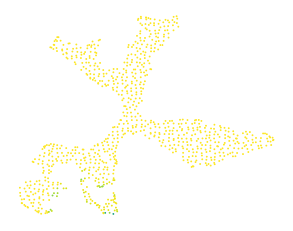

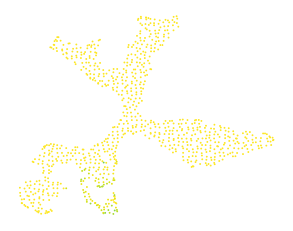

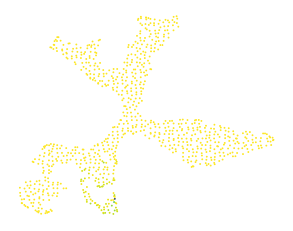

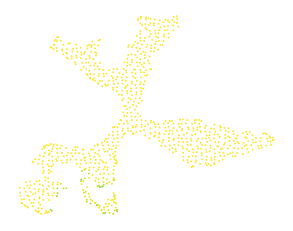

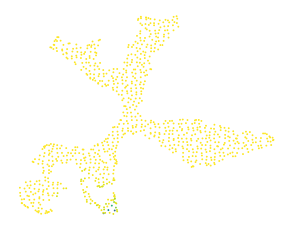

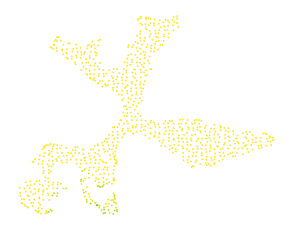

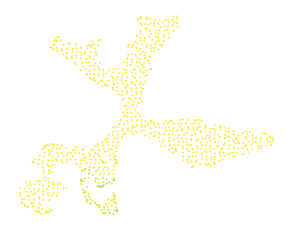

In [437]:
for i in embedding_lookup[embedding_lookup.clusters == 'OPC'].down_sample_index:
    view_state(probability_matrix[i,:])
    plt.show()
    

In [398]:
embedding_lookup[embedding_lookup.clusters == 'OPC'].down_sample_index

3321     176
3493     193
3949     213
4095     226
5295     288
6103     321
7918     412
8661     451
9474     475
9687     481
10827    527
12215    601
12232    602
12783    624
13067    639
13166    648
13407    659
13417    660
13521    665
14237    702
14812    727
15780    777
16064    790
16069    791
16083    792
16754    822
17034    835
17159    841
17167    842
17255    847
17583    864
Name: down_sample_index, dtype: int64

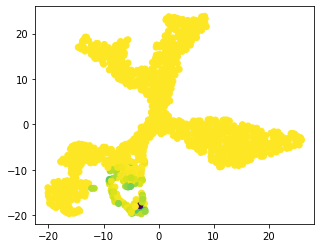

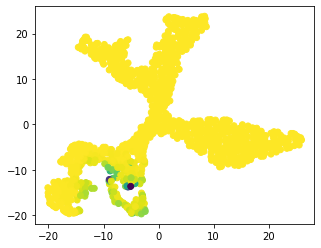

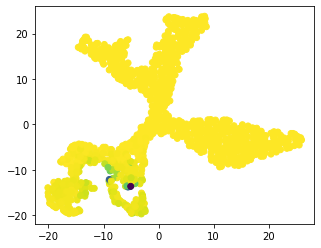

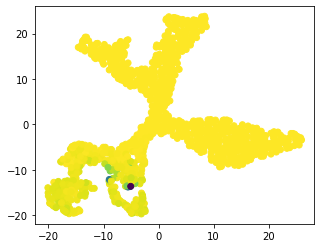

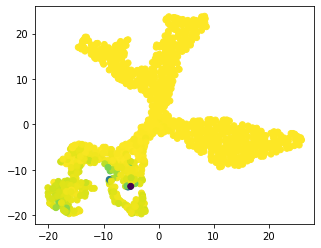

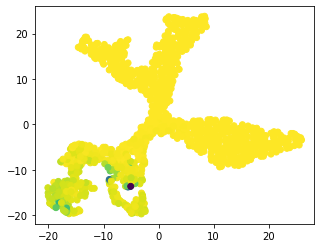

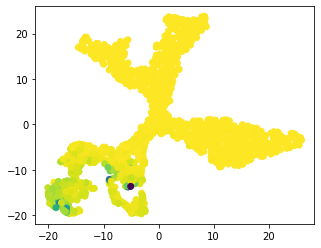

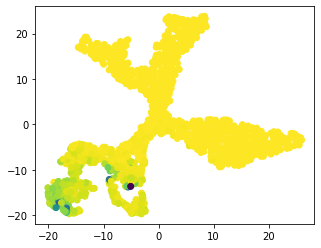

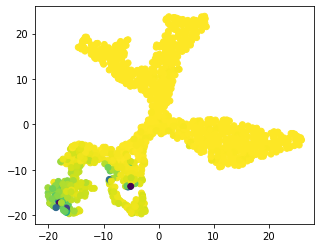

In [381]:
plt.rcParams["figure.figsize"] = (5,4)

ncells = probability_matrix.shape[0]
startState = np.zeros(ncells)
for i in embedding_lookup[embedding_lookup.clusters == 'OPC'].down_sample_index:
    startState[i]=1
    break

startState /= startState.sum()

# starting from uniform distribution
#startState = np.ones(ncells)/ncells

for i in range(1,10):
    endState = run_Markov(startState, probability_matrix, nsteps=i)

# nature trick =.=
#endState = endState - np.percentile(endState, 3)
#endState /= np.percentile(endState, 97)
#endState = np.clip(endState,0,1)

    plt.scatter(embedding[sampling_ixs,0], embedding[sampling_ixs,1], c=endState, 
            cmap="viridis_r")
    #plt.colorbar()
    #plt.axis('off')
    plt.show()




In [353]:
from scipy.linalg import eig
w, vl, vr = eig(probability_matrix, left=True)

In [360]:
def eigs(T, k=10, eps=1e-3, perc=None, random_state=None, v0=None):
    if random_state is not None:
        np.random.seed(random_state)
        v0 = np.random.rand(min(T.shape))
    try:
        # find k eigs with largest real part, and sort in descending order of eigenvals
        eigvals, eigvecs = linalg.eigs(T.T, k=k, which="LR", v0=v0)
        p = np.argsort(eigvals)[::-1]
        eigvals = eigvals.real[p]
        eigvecs = eigvecs.real[:, p]

        # select eigenvectors with eigenvalue of 1 - eps.
        idx = eigvals >= 1 - eps
        eigvals = eigvals[idx]
        eigvecs = np.absolute(eigvecs[:, idx])

        if perc is not None:
            lbs, ubs = np.percentile(eigvecs, perc, axis=0)
            eigvecs[eigvecs < lbs] = 0
            eigvecs = np.clip(eigvecs, 0, ubs)
            eigvecs /= eigvecs.max(0)

    except Exception:
        eigvals, eigvecs = np.empty(0), np.zeros(shape=(T.shape[0], 0))

    return eigvals, eigvecs

In [371]:
val, vec = eigs(probability_matrix)

In [369]:
vec

array([], shape=(888, 0), dtype=float64)

(-22.40861812067398, 28.25126337193278, -21.86207287535866, 25.970700870903457)

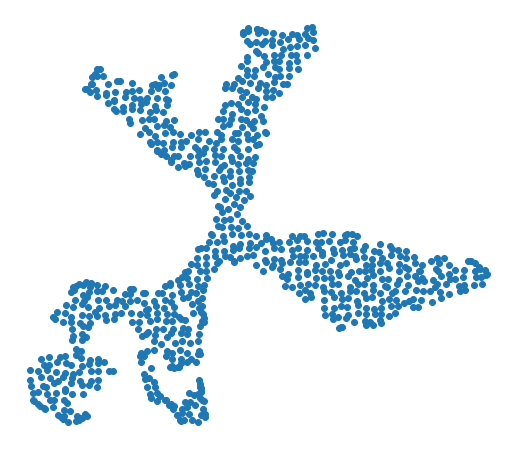

In [370]:
plt.rcParams["figure.figsize"] = (9,8)
plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2)
plt.axis('off')

1.0

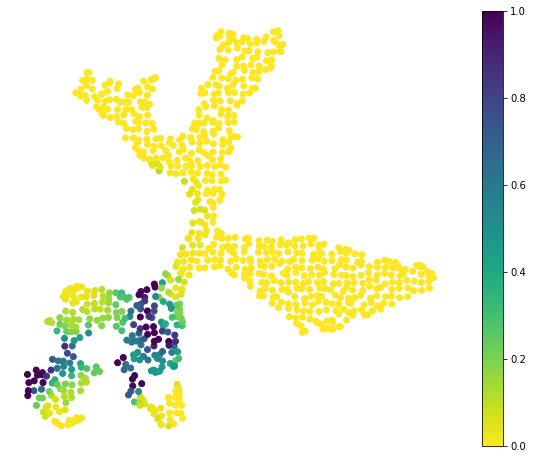

In [28]:
# backward diffusion
temp = transition_matrix.T
b_transition_matrix = temp/(temp.sum(1)[:,None])

startState = np.zeros(ncells)
for i in embedding_lookup[embedding_lookup.clusters == 'nIPC'].down_sample_index:
    startState[i]=1
startState /= startState.sum()
#startState = np.ones(ncells)/ncells



endState = run_Markov(startState, b_transition_matrix, nsteps=20000)

endState = endState - np.percentile(endState, 3)
endState /= np.percentile(endState, 97)
endState = np.clip(endState,0,1)

plt.scatter(embedding[sampling_ixs,0], embedding[sampling_ixs,1], c=endState, 
            cmap="viridis_r", vmin=0)
plt.colorbar()
plt.axis('off')

endState.max()

In [683]:
# Analytically solving for the forward stationary state.

def Markov_stationary(transition_matrix):
    ncells = np.shape(transition_matrix)[0]
    A = np.append(np.transpose(m)-np.identity(ncells),np.ones(ncells)[None, :],axis=0)
    # b is composed of zeros with 1 for the last dimension.
    b= np.transpose(np.append(np.zeros(ncells),np.array([1])))

    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

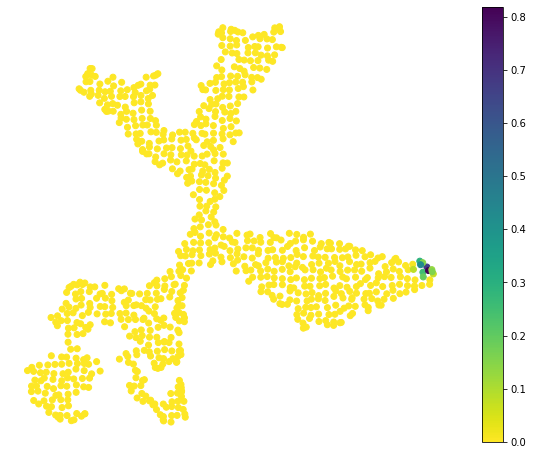

In [686]:
m = transition_matrix

endState = Markov_stationary(m)
plt.scatter(embedding[sampling_ixs,0], embedding[sampling_ixs,1], c=endState, 
            cmap="viridis_r", vmin=0)
plt.axis("off")
plt.colorbar()

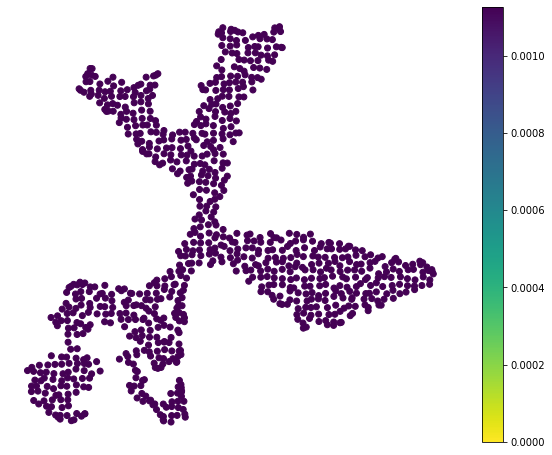

In [688]:
# Analytically solving for the backward stationary state.
n = m.T
n /= n.sum(1)[:,None]
endState = Markov_stationary(n)
plt.scatter(embedding[sampling_ixs,0], embedding[sampling_ixs,1], c=endState, cmap="viridis_r", vmin=0)
plt.axis("off")
plt.colorbar()

In [664]:
embedding_lookup.clusters.drop_duplicates()

12          CA1-Sub
46      ImmGranule2
60             nIPC
88          Granule
91               CA
124     ImmGranule1
183         CA2-3-4
221      RadialGlia
256        ImmAstro
330            Nbl1
423       GlialProg
1276           Nbl2
1330    RadialGlia2
3321            OPC
Name: clusters, dtype: object

In [472]:
    
    # sigma_D is set to the average distance between the closest neighbours
    mix_ratio = 0.2
    prob_matrix = probability_matrix
    X = pairwise_distances(embedding_downsampling.to_numpy())
    
    X_temp = X + np.identity(X.shape[0])*X.max()
    near_dist = X_temp.min(axis=0)
    sigma_D = near_dist.mean()
    sigma_W = 0.5 * sigma_D
    W = gaussian_kernel(X, sigma=sigma_W) * mix_ratio 
    
    # prevent self-diffusion
    np.fill_diagonal(W,0)
    
    D = prob_matrix * gaussian_kernel(X, sigma=sigma_D) * (1-mix_ratio)
    T = W + D
    knnT = T*knn_embedding.A
    T = T/T.sum(1)[:,None]
    knnT = knnT/knnT.sum(1)[:,None]

In [580]:
def mean_diffusion_time(transition_matrix, startState, finalState):
    '''
    Assuming the time to travel from each pair of cells is equal
    i.e., for any (i,j), delta_t(i,j)= dt = 1
    Calculating from numerical simulations
    '''
    
    

In [45]:
a = np.array([0,2,1])

In [46]:
# nature trick =.=
np.percentile(a, 3)


0.06

In [33]:
a /= np.percentile(a, 97)
a = np.clip(a,0,1)

In [38]:
help(np.percentile)

Help on function percentile in module numpy:

percentile(a, q, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)
    Compute the q-th percentile of the data along the specified axis.
    
    Returns the q-th percentile(s) of the array elements.
    
    Parameters
    ----------
    a : array_like
        Input array or object that can be converted to an array.
    q : array_like of float
        Percentile or sequence of percentiles to compute, which must be between
        0 and 100 inclusive.
    axis : {int, tuple of int, None}, optional
        Axis or axes along which the percentiles are computed. The
        default is to compute the percentile(s) along a flattened
        version of the array.
    
        .. versionchanged:: 1.9.0
            A tuple of axes is supported
    out : ndarray, optional
        Alternative output array in which to place the result. It must
        have the same shape and buffer length as the expected output,
     

In [272]:
P = np.array([[0.2, 0.7, 0.1],
              [0.9, 0.0, 0.1],
              [0.2, 0.8, 0.0]])
stateChangeHist= np.array([[0.0,  0.0,  0.0],
                          [0.0, 0.0,  0.0],
                          [0.0, 0.0,  0.0]])
state=np.array([[1.0, 0.0, 0.0]])
currentState=0
stateHist=state
dfStateHist=pd.DataFrame(state)
distr_hist = [[0,0,0]]
random.seed(4)

# Simulate from multinomial distribution
def simulate_multinomial(vmultinomial):
  r=np.random.uniform(0.0, 1.0)
  CS=np.cumsum(vmultinomial)
  CS=np.insert(CS,0,0)
  m=(np.where(CS<r))[0]
  nextState=m[len(m)-1]
  return nextState

for x in range(1000):
  currentRow=np.ma.masked_values((P[currentState]), 0.0)
  nextState=simulate_multinomial(currentRow)
  # Keep track of state changes
  stateChangeHist[currentState,nextState]+=1
  # Keep track of the state vector itself
  state=np.array([[0,0,0]])
  state[0,nextState]=1.0
  # Keep track of state history
  stateHist=np.append(stateHist,state,axis=0)
  currentState=nextState
  # calculate the actual distribution over the 3 states so far
  totals=np.sum(stateHist,axis=0)
  gt=np.sum(totals)
  distrib=totals/gt
  distrib=np.reshape(distrib,(1,3))
  distr_hist=np.append(distr_hist,distrib,axis=0)

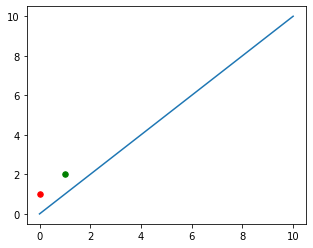

In [449]:
plt.plot([0,10],[0,10])
plt.scatter([0],[1],s=30,color='red')
plt.scatter([1],[2],s=30,color='g')